In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr

from salishsea_tools import viz_tools, geo_tools
import netCDF4 as nc
import arrow
import copy
import math
import matplotlib.dates as mdates
from pathlib import Path
import gsw

Paths to collection of obs datasets and load them, and to a specific dataset:

In [2]:
obs_dir = Path("/ocean/atall/MOAD/Obs/PugetSound/ERDDAP/")
obs_file_TW = obs_dir / "L2_gridded_025_TW_20100101-20101231.nc"
ds_obs_TW = xr.open_dataset(obs_file_TW)
obs_file_HS = obs_dir / "L2_gridded_025_HS_20100101-20101231.nc"
ds_obs_HS = xr.open_dataset(obs_file_HS)
obs_file_NB = obs_dir / "L2_gridded_025_NB_20100101-20101231.nc"
ds_obs_NB = xr.open_dataset(obs_file_NB)


Obs variables

In [3]:
# Twanoh
depth_obs_TW = ds_obs_TW.depth.sel()
time_obs_TW = ds_obs_TW.cast_start_time.sel()
oxy_obs_TW = ds_obs_TW.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_TW = ds_obs_TW.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_TW = ds_obs_TW.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_TW = gsw.SR_from_SP(ds_obs_TW.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_TW = gsw.CT_from_t(salt_obs_TW, ds_obs_TW.sea_water_temperature.sel(), ds_obs_TW.sea_water_pressure.sel()) # from in-situ temp to cons temp
# Hoodsport
depth_obs_HS = ds_obs_HS.depth.sel()
time_obs_HS = ds_obs_HS.cast_start_time.sel()
oxy_obs_HS = ds_obs_HS.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_HS = ds_obs_HS.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_HS = ds_obs_HS.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_HS = gsw.SR_from_SP(ds_obs_HS.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_HS = gsw.CT_from_t(salt_obs_HS, ds_obs_HS.sea_water_temperature.sel(), ds_obs_HS.sea_water_pressure.sel()) # from in-situ temp to cons temp
# NorthBuoy
depth_obs_NB = ds_obs_NB.depth.sel()
time_obs_NB = ds_obs_NB.cast_start_time.sel()
oxy_obs_NB = ds_obs_NB.mass_concentration_of_oxygen_in_sea_water.sel() * 44.64
chl_obs_NB = ds_obs_NB.mass_concentration_of_chlorophyll_a_in_sea_water.sel()
no3_obs_NB = ds_obs_NB.mole_concentration_of_nitrate_in_sea_water.sel()
salt_obs_NB = gsw.SR_from_SP(ds_obs_NB.sea_water_practical_salinity.sel()) # from practical to ref salinity (g/kg)
temp_obs_NB = gsw.CT_from_t(salt_obs_NB, ds_obs_NB.sea_water_temperature.sel(), ds_obs_NB.sea_water_pressure.sel()) # from in-situ temp to cons temp


Buoys position :  https://nwem.apl.washington.edu/prod_PugetSound.shtml

In [4]:
mycmap = copy.copy(cm.oxy)
mycmap.set_bad('darkgreen')

In [5]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc') as mesh:
    tmask = mesh.tmask
    mbathy = mesh.mbathy

In [6]:
# Constant and data rang
syear = 2010
eyear = 2010
smonth = 1
emonth = 12
startdate = arrow.get(syear, smonth, 1)
enddate = arrow.get(eyear, emonth, 31)
print (startdate, enddate)

2010-01-01T00:00:00+00:00 2010-12-31T00:00:00+00:00


In [7]:
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_chem_T.nc') as data_chem:
    oxy = data_chem['dissolved_oxygen']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_biol_T.nc') as data_biol:
    no3 = data_biol['nitrate']
    don = data_biol['dissolved_organic_nitrogen']
    pon = data_biol['particulate_organic_nitrogen']
    dia = data_biol['diatoms']
    fla = data_biol['flagellates']
with xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01apr23/SalishSea_1d_20230401_20230401_grid_T.nc') as data_grid:
    temp = data_grid['votemper']
    salt = data_grid['vosaline']
#    dens = data_grid['sigma_theta'] # almost same as salinity

In [8]:
tmask2_oxy = tmask.assign_coords(z=("z", oxy.deptht.data))
tmask2_oxy = tmask2_oxy.rename({"z": "deptht"})
tmask2_no3 = tmask.assign_coords(z=("z", no3.deptht.data))
tmask2_no3 = tmask2_no3.rename({"z": "deptht"})
tmask2_dia = tmask.assign_coords(z=("z", dia.deptht.data))
tmask2_dia = tmask2_dia.rename({"z": "deptht"})
tmask2_fla = tmask.assign_coords(z=("z", fla.deptht.data))
tmask2_fla = tmask2_fla.rename({"z": "deptht"})
tmask2_temp = tmask.assign_coords(z=("z", temp.deptht.data))
tmask2_temp = tmask2_temp.rename({"z": "deptht"})
tmask2_salt = tmask.assign_coords(z=("z", salt.deptht.data))
tmask2_salt = tmask2_salt.rename({"z": "deptht"})


In [9]:
print (oxy.deptht)

<xarray.DataArray 'deptht' (deptht: 40)>
array([  0.5     ,   1.500003,   2.500011,   3.500031,   4.500071,   5.500151,
         6.50031 ,   7.500623,   8.501236,   9.502433,  10.504766,  11.509312,
        12.518167,  13.535412,  14.568982,  15.634288,  16.761173,  18.007135,
        19.481785,  21.389978,  24.100256,  28.229916,  34.685757,  44.517723,
        58.484333,  76.58559 ,  98.06296 , 121.866516, 147.08946 , 173.11449 ,
       199.57304 , 226.2603  , 253.06664 , 279.93454 , 306.8342  , 333.75018 ,
       360.67453 , 387.6032  , 414.5341  , 441.4661  ], dtype=float32)
Coordinates:
  * deptht   (deptht) float32 0.5 1.5 2.5 3.5 4.5 ... 360.7 387.6 414.5 441.5
Attributes:
    standard_name:  sea_floor_depth
    long_name:      Sea Floor Depth
    units:          metres
    positive:       down


Buoy position in 202111 (4x4 pixels around)

In [10]:
#i1, i2, j1, j2 = (95, 200, 68, 160)  # Hood Canal all
i1pw, i2pw, j1pw, j2pw = (257, 260, 102, 105)  # Point Wells 47.761N, -122.3972W 100 meters depth
i1ci, i2ci, j1ci, j2ci = (151, 154, 29,32)  # Carr Inlet - 47.28N, -122.728W 47 meters depth
i1db, i2db, j1db, j2db = (204, 207, 140, 143)  # Babob bay 47.8034N, -122.8029W 100 meters depth
i1nb, i2nb, j1nb, j2nb = (241, 244, 147, 150)  # Northbuoy (Hansville)
i1hs, i2hs, j1hs, j2hs = (107, 110, 83, 86)           # Hoodsport buoy point in Lynch Cove (Hood Canal) - 47.4218N, -123.1126W 120 meters depth
i1lc, i2lc, j1lc, j2lc = (122, 125, 70, 73)  # Twanoh buoy point in Lynch Cove (Hood Canal) - 47.375N, -123.0083W 35 meters depth

#(j1lc,i1lc)=geo_tools.find_closest_model_point(-123.008, 47.375, grid='GEM2.5')

In [11]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_chem = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_chem_T.nc'
    with xr.open_dataset(filename_chem) as ds_chem:
        oxyhs = ds_chem['dissolved_oxygen'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_oxy[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        oxylc = ds_chem['dissolved_oxygen'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_oxy[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        oxynb = ds_chem['dissolved_oxygen'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_oxy[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
        if first:
            first = False
            oxyhs_ts = oxyhs
            oxylc_ts = oxylc
            oxynb_ts = oxynb
        else:
            oxyhs_ts = xr.concat([oxyhs_ts, oxyhs], dim='time_counter')
            oxylc_ts = xr.concat([oxylc_ts, oxylc], dim='time_counter')
            oxynb_ts = xr.concat([oxynb_ts, oxynb], dim='time_counter')

In [12]:
no3_obs_HS.shape


(1843, 481)

In [15]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_biol = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_biol_T.nc'
    with xr.open_dataset(filename_biol) as ds_biol:
        no3hs = ds_biol['nitrate'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_no3[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        no3lc = ds_biol['nitrate'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_no3[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        no3nb = ds_biol['nitrate'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_no3[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
        
        dialc = ds_biol['diatoms'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_dia[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        diahs = ds_biol['diatoms'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_dia[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        dianb = ds_biol['diatoms'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_dia[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
        
        flalc = ds_biol['flagellates'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_fla[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        flahs = ds_biol['flagellates'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_fla[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        flanb = ds_biol['flagellates'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_fla[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
        
        if first:
            first = False
            no3hs_ts = no3hs
            no3lc_ts = no3lc
            no3nb_ts = no3nb
         
            dialc_ts = dialc
            diahs_ts = diahs
            dianb_ts = dianb
         
            flalc_ts = flalc
            flahs_ts = flahs
            flanb_ts = flanb
        else:
            no3hs_ts = xr.concat([no3hs_ts, no3hs], dim='time_counter')
            no3lc_ts = xr.concat([no3lc_ts, no3lc], dim='time_counter')
            no3nb_ts = xr.concat([no3nb_ts, no3nb], dim='time_counter')
        
            dialc_ts = xr.concat([dialc_ts, dialc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            dianb_ts = xr.concat([dianb_ts, dianb], dim='time_counter')
         
            flalc_ts = xr.concat([flalc_ts, flalc], dim='time_counter')
            diahs_ts = xr.concat([diahs_ts, diahs], dim='time_counter')
            flanb_ts = xr.concat([flanb_ts, flanb], dim='time_counter')
         

In [16]:
chllc_ts = (dialc_ts + flalc_ts) * 2
chlhs_ts = (diahs_ts + flahs_ts) * 2
chlnb_ts = (dianb_ts + flanb_ts) * 2


In [18]:
first = True
for ii, day in enumerate(arrow.Arrow.range('day', startdate, enddate)):
    year = day.year
    yr2 = day.strftime("%y")
    month = day.month
    Month = day.strftime("%b").lower()
    day = day.day
    # set up filename to follow NEMO conventions
    filename_grid = f'/results2/SalishSea/nowcast-green.202111/{day:02}{Month}{yr2}/SalishSea_1d_{year}{month:02}{day:02}_{year}{month:02}{day:02}_grid_T.nc'
    with xr.open_dataset(filename_grid) as ds_grid:
        temphs = ds_grid['votemper'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_temp[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        templc = ds_grid['votemper'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_temp[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        tempnb = ds_grid['votemper'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_temp[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
        
        salths = ds_grid['vosaline'][0, :, j1hs:j2hs, i1hs:i2hs].where(tmask2_salt[0, :, j1hs:j2hs, i1hs:i2hs] == 1).mean(axis=1).mean(axis=1)
        saltlc = ds_grid['vosaline'][0, :, j1lc:j2lc, i1lc:i2lc].where(tmask2_salt[0, :, j1lc:j2lc, i1lc:i2lc] == 1).mean(axis=1).mean(axis=1)
        saltnb = ds_grid['vosaline'][0, :, j1nb:j2nb, i1nb:i2nb].where(tmask2_salt[0, :, j1nb:j2nb, i1nb:i2nb] == 1).mean(axis=1).mean(axis=1)
          
        if first:
            first = False
            temphs_ts = temphs
            templc_ts = templc
            tempnb_ts = tempnb
        
            salths_ts = salths
            saltlc_ts = saltlc
            saltnb_ts = saltnb
        else:
            temphs_ts = xr.concat([temphs_ts, temphs], dim='time_counter')
            templc_ts = xr.concat([templc_ts, templc], dim='time_counter')
            tempnb_ts = xr.concat([tempnb_ts, tempnb], dim='time_counter')
        
            salths_ts = xr.concat([salths_ts, salths], dim='time_counter')
            saltlc_ts = xr.concat([saltlc_ts, saltlc], dim='time_counter')
            saltnb_ts = xr.concat([saltnb_ts, saltnb], dim='time_counter')
        

Twanoh in Lynch Cove - Hood Canal

Twanoh in Lynch Cove - Hood Canal 2010-01-01T00:00:00+00:00 2010-12-31T00:00:00+00:00


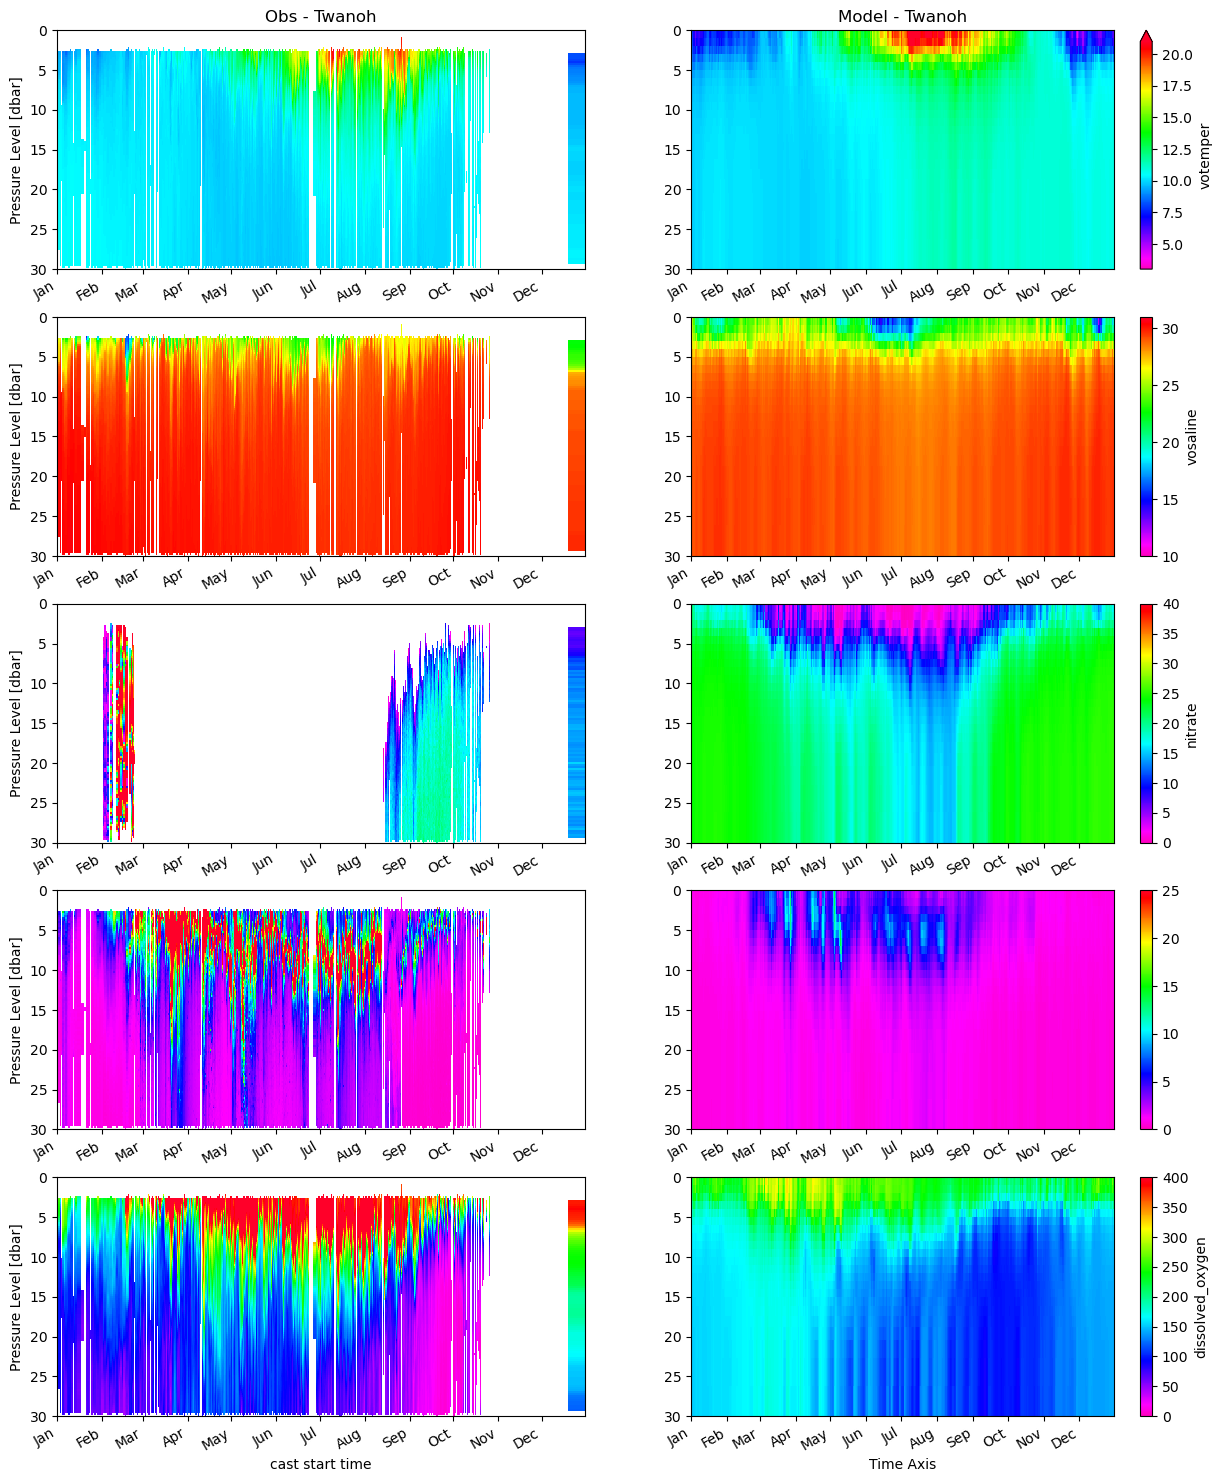

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_TW.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=3, vmax=21, ylim=(30, 0), xlim=(startdate, enddate));
salt_obs_TW.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=10, vmax=31, ylim=(30, 0), xlim=(startdate, enddate));
no3_obs_TW.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=40, ylim=(30, 0), xlim=(startdate, enddate));
chl_obs_TW.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(30, 0), xlim=(startdate, enddate));
oxy_obs_TW.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=400, ylim=(30, 0), xlim=(startdate, enddate));

templc_ts[:, :24].plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(30, 0), xlim=(startdate, enddate));
saltlc_ts[:, :24].plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=10, vmax=31, ylim=(30, 0), xlim=(startdate, enddate));
no3lc_ts[:, :24].plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=40, ylim=(30, 0), xlim=(startdate, enddate));
chllc_ts[:, :24].plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(30, 0), xlim=(startdate, enddate));
oxylc_ts[:, :24].plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(30, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - Twanoh')
ax[0, 1].set_title('Model - Twanoh')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('Twanoh in Lynch Cove - Hood Canal', startdate, enddate)

Hoodsport - central Hood Canal

Hoodsport in central Hood Canal 2010-01-01T00:00:00+00:00 2010-12-31T00:00:00+00:00


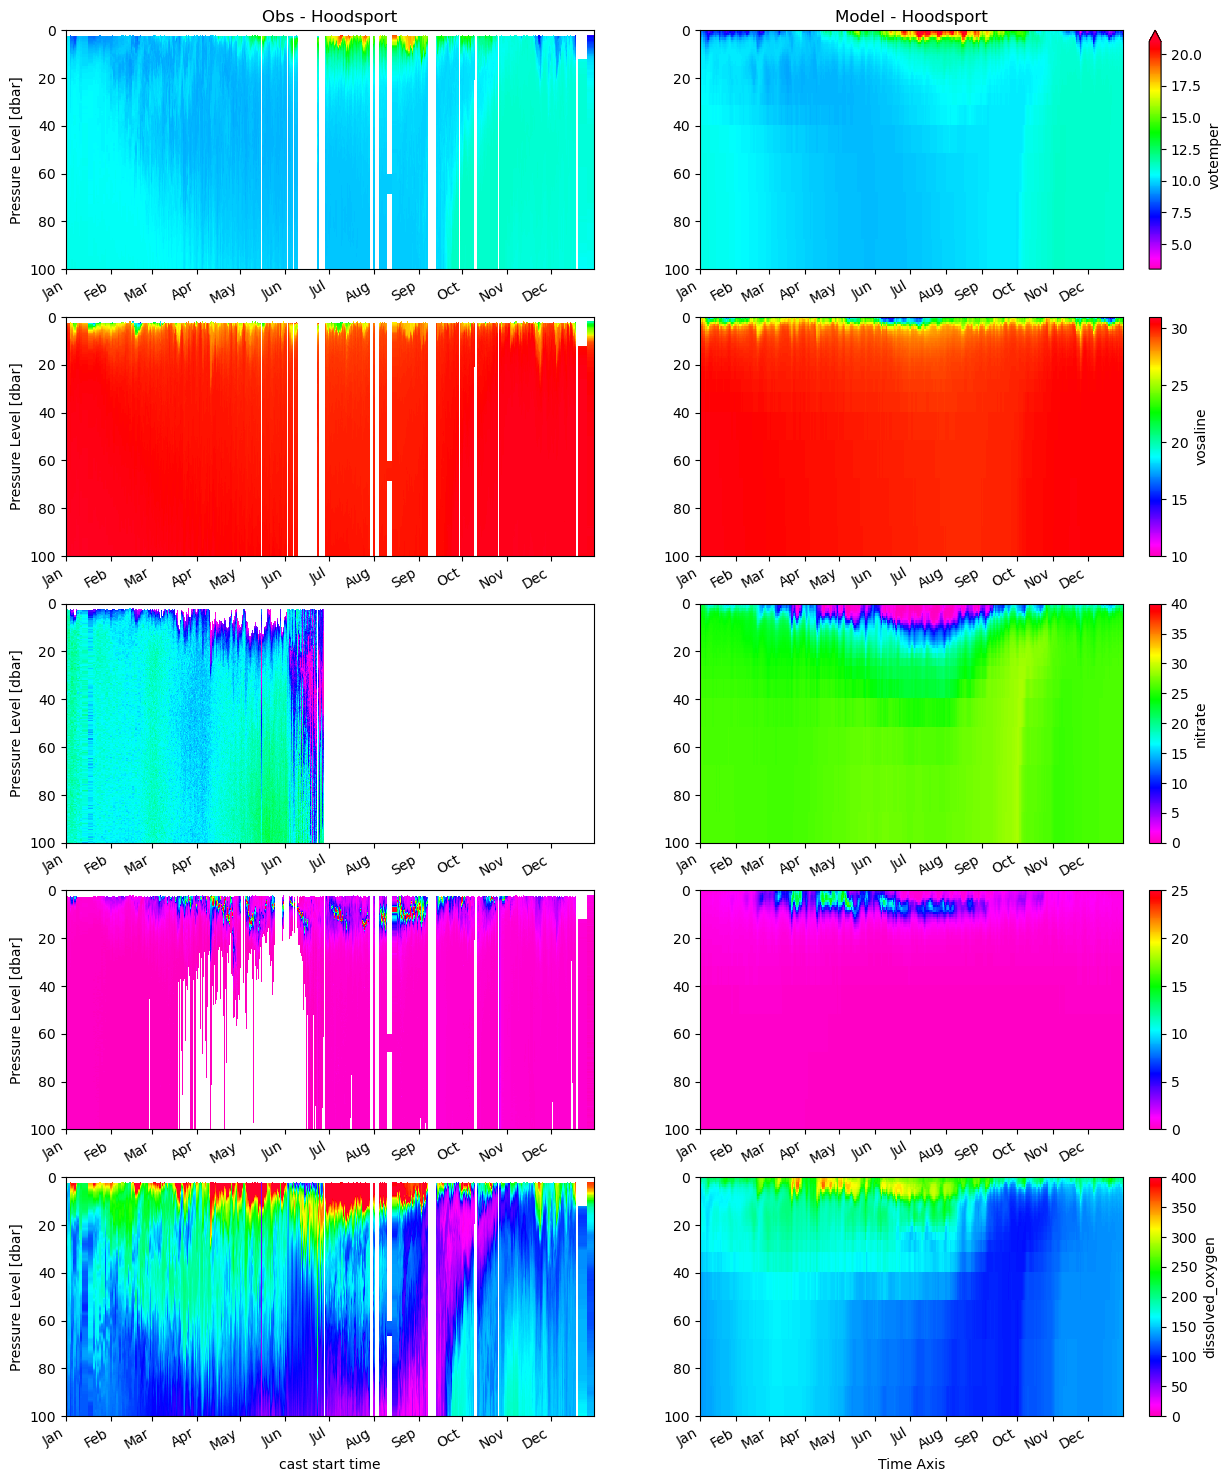

In [20]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_HS.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=3, vmax=21, ylim=(100, 0), xlim=(startdate, enddate));
salt_obs_HS.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=10, vmax=31, ylim=(100, 0), xlim=(startdate, enddate));
no3_obs_HS.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=40, ylim=(100, 0), xlim=(startdate, enddate));
chl_obs_HS.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(100, 0), xlim=(startdate, enddate));
oxy_obs_HS.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=400, ylim=(100, 0), xlim=(startdate, enddate));

temphs_ts.plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(100, 0), xlim=(startdate, enddate));
salths_ts.plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=10, vmax=31, ylim=(100, 0), xlim=(startdate, enddate));
no3hs_ts.plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=40, ylim=(100, 0), xlim=(startdate, enddate));
chlhs_ts.plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(100, 0), xlim=(startdate, enddate));
oxyhs_ts.plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(100, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - Hoodsport')
ax[0, 1].set_title('Model - Hoodsport')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('Hoodsport in central Hood Canal', startdate, enddate)

North buoy (Hansville) - Hood Canal

North buoy - Hood Canal 2010-01-01T00:00:00+00:00 2010-12-31T00:00:00+00:00


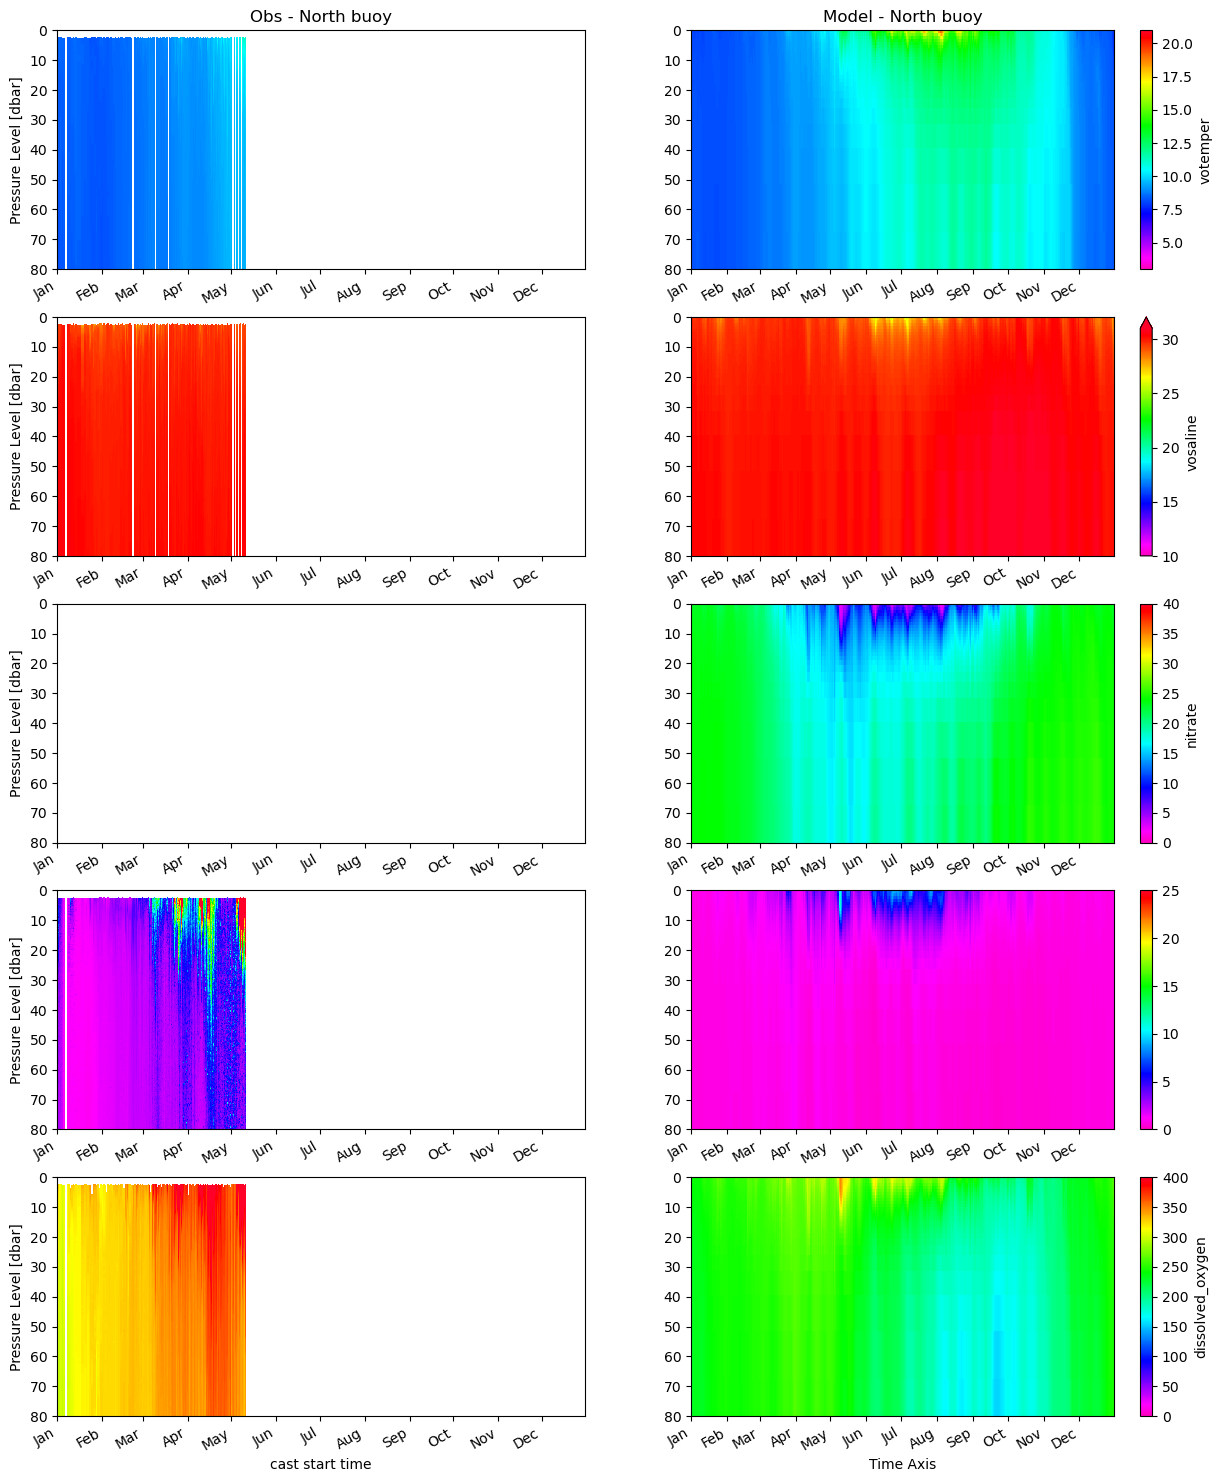

In [21]:
fig, ax = plt.subplots(5, 2, figsize=(15, 18))
temp_obs_NB.plot(ax=ax[0, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=3, vmax=21, ylim=(80, 0), xlim=(startdate, enddate));
salt_obs_NB.plot(ax=ax[1, 0], y="sea_water_pressure", yincrease=False, cmap= 'gist_rainbow_r', add_colorbar=False, vmin=10, vmax=31, ylim=(80, 0), xlim=(startdate, enddate));
no3_obs_NB.plot(ax=ax[2, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=40, ylim=(80, 0), xlim=(startdate, enddate));
chl_obs_NB.plot(ax=ax[3, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=25, ylim=(80, 0), xlim=(startdate, enddate));
oxy_obs_NB.plot(ax=ax[4, 0], y="sea_water_pressure", yincrease=False, cmap='gist_rainbow_r', add_colorbar=False, vmin=0, vmax=400, ylim=(80, 0), xlim=(startdate, enddate));

tempnb_ts.plot(ax=ax[0, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=3, vmax=21, ylim=(80, 0), xlim=(startdate, enddate));
saltnb_ts.plot(ax=ax[1, 1], y="deptht", yincrease=False, cmap= 'gist_rainbow_r', vmin=10, vmax=31, ylim=(80, 0), xlim=(startdate, enddate));
no3nb_ts.plot(ax=ax[2, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=40, ylim=(80, 0), xlim=(startdate, enddate));
chlnb_ts.plot(ax=ax[3, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=25, ylim=(80, 0), xlim=(startdate, enddate));
oxynb_ts.plot(ax=ax[4, 1], y="deptht", yincrease=False, cmap='gist_rainbow_r', vmin=0, vmax=400, ylim=(80, 0), xlim=(startdate, enddate));

ax[0, 1].set_ylabel('')
ax[1, 1].set_ylabel('')
ax[2, 1].set_ylabel('')
ax[3, 1].set_ylabel('')
ax[4, 1].set_ylabel('')
ax[0, 0].set_xlabel('')
ax[1, 0].set_xlabel('')
ax[2, 0].set_xlabel('')
ax[3, 0].set_xlabel('')
ax[0, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[2, 1].set_xlabel('')
ax[3, 1].set_xlabel('')

ax[0, 0].set_title('Obs - North buoy')
ax[0, 1].set_title('Model - North buoy')

# Make ticks on occurrences of each month:
ax[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 0].xaxis.set_major_locator(mdates.MonthLocator())
ax[0, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[1, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[2, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[3, 1].xaxis.set_major_locator(mdates.MonthLocator())
ax[4, 1].xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 0].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[2, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[3, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax[4, 1].xaxis.set_major_formatter(mdates.DateFormatter('%b'))

print('North buoy - Hood Canal', startdate, enddate)